In [2]:
import numpy as np
from env import env as Env
from taskexp import Task
import sys
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from policysearch import PolicySearch_Agent as PolicySearch_Agent

In [3]:
add_meteor = False
sim_vs = [[.0001]]

In [4]:
num_episodes = 5000
sim_scores = []
for sim_v in sim_vs:
    env = Env()
    init_loc = env.init_loc
    target = env.target
    episode_scores = []
    average_reward_per_step = []
    play_steps = []
    task = Task(init_pose = init_loc, init_velocities = [0., 0., 0.,], 
                init_angle_velocities = [0., 0., 0.], target_pos = target, action_repeat=1)
    meteor_v = sim_v
    agent = PolicySearch_Agent(task, env, add_obsticles = True, add_meteors = add_meteor, meteor_vs = meteor_v)
    for i_episode in range(1, num_episodes+1):
        if add_meteor:
            meteor_vector_v = env.get_meteors_vel()
        state = agent.reset_episode(create_meteor = add_meteor, meteor_vs = meteor_v) # start a new episode
        while True:
            action = agent.act(state)
            if add_meteor:
                env.update_meteors()
                rads = env.get_meteors_rads()
                m_pos = env.get_meteors_pos()
                m_ds = np.power(np.power(state[:3] - m_pos, 2), 0.5).sum()
                next_state, reward, done, early_stop = task.step(action, env.obsticle_bounderies, env.wall_boundaries, 
                                                     meteor_ds = m_ds, meteors_rads = rads)
            else:
                next_state, reward, done, early_stop = task.step(action, env.obsticle_bounderies, env.wall_boundaries)            
            agent.step(reward, done)
            state = next_state
            if done:
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                    i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
                episode_scores.append(agent.score)
                average_reward_per_step.append(agent.score * agent.count)
                break
        sys.stdout.flush()
        if i_episode % 100 == 0:
            steps = 0
            state = agent.reset_episode(create_meteor = add_meteor, meteor_vs = meteor_v)
            while True:
                action = agent.act(state)
                next_state, reward, done, early_stop = task.step(action, env.obsticle_bounderies, env.wall_boundaries)
                agent.step(reward, done, learnFlag = False)
                state = next_state
                steps += 1
                if done:
                    play_steps.append(steps)
                    break
    print(" Scenario: ", meteor_v)
    del task
    del agent
    del env
    sim_scores.append(episode_scores)

Episode = 5000, score =   0.769 (best =   0.786), noise_scale = 3.255 Scenario:  [0.0001]


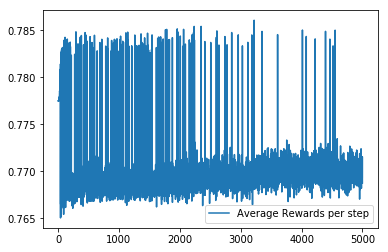

In [5]:
rewards_label = ["Average Rewards per step"]
for episode_score in sim_scores:
    plt.plot(episode_score)
    plt.legend(rewards_label)
    plt.show()

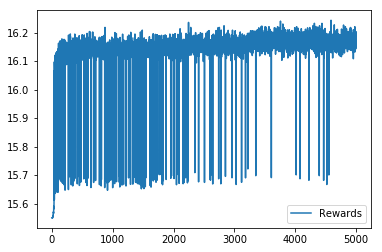

In [6]:
rewards_label = ["Rewards"]
for episode_score in sim_scores:
    plt.plot(average_reward_per_step)
    plt.legend(rewards_label)
    plt.show()

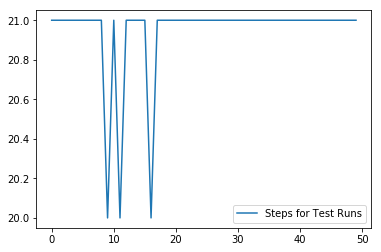

In [7]:
rewards_label = ["Steps for Test Runs"]
for episode_score in sim_scores:
    plt.plot(play_steps)
    plt.legend(rewards_label)
    plt.show()